<a href="https://colab.research.google.com/github/Kim-Hyerin/pdm06/blob/master/py-tensorflow/tf2_7_fmnist_CNN_best_pdm06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [DIY] fashion mnist model의 best model을 구하시오.

- github의 "py-tensorflow" 폴더에 tf2_7_fmnist_CNN_best.ipynb 파일을 올리시오. 
- github의 "py-tensorflow/st-code/model" 폴더에 best model(hdf5 파일)을 올리시오. 

> fashion mnist 데이터 로딩
```
from keras.datasets import fashion_mnist
(X_train0, y_train0), (X_test0, y_test0) = fashion_mnist.load_data()
```

### callbacks

- cp_callback = callbacks.ModelCheckpoint(filepath="./fmnist_c2f2_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", monitor='val_accuracy', verbose=0, save_best_only=True)

- es_callback = callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=50) # patience=10, 20, 50

# **CNN model of fmnist dataset**
- Conv2D + FCN
    * Conv2D : 2차원 합성곱 필터링 + 풀링(Pooling)
    * FCN : 1차원 완전연결신경망

***
- ## Traget: Find the best model
***

![mnist_NN_2_layers](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdJp5Z6%2FbtqAPebnF3x%2FQCe5vVcskhmxe964bGz4iK%2Fimg.png)

(source: https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdJp5Z6%2FbtqAPebnF3x%2FQCe5vVcskhmxe964bGz4iK%2Fimg.png)

## dataset: fashion_mnist
- (60000, 28, 28), train
- (10000, 28, 28), test
- grayscale images of items of 10 types of clothings, such as shoes, t-shirts, dresses, and more.
- class names
> class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

- DL of fmnist
> https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/


## Search the best model of C2F2
- callback
    - Early stopping
    - model checkpoint

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

tf.random.set_seed(0)

print(tf.__version__)

2.3.0


In [2]:
# import TF2 submodules
from tensorflow.keras import layers, models, callbacks

## **데이터 로딩, 정규화**

In [3]:
from keras.datasets import fashion_mnist

(X_train0, y_train0), (X_test0, y_test0) = fashion_mnist.load_data()

# Reshape
X_train = X_train0.reshape(60000,28,28,1)
X_test = X_test0.reshape(10000,28,28,1)

# Normalization
X_train, X_test = X_train/255.0, X_test/255.0 # 정규화

print("X_train={0}".format(X_train.shape))
print("y_train={0}".format(y_train0.shape)) 
print("X_test={0}".format(X_test.shape))
print("y_test={0}".format(y_test0.shape))

4423680/4422102 [==============================] - 0s 0us/step
X_train=(60000, 28, 28, 1)
y_train=(60000,)
X_test=(10000, 28, 28, 1)
y_test=(10000,)


In [4]:
# One-Hot-Encoding
# Use function to_categorical() to do One-Hot-Encoding
# tf.keras.utils.to_categorical
from keras.utils import to_categorical

y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)
y_train.shape,y_test.shape

((60000, 10), (10000, 10))

In [5]:
# y_train0.shape vs. y_train.shape
y_train0.shape, y_train.shape

((60000,), (60000, 10))

### Display fashions
- one random fashion
- 10 representative fashions

48393


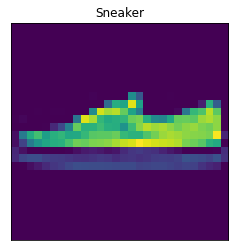

In [9]:
# Code here!
# display one random image from the training set:
class_names =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

idx = np.random.randint(0, X_train0.shape[0])
print(idx)
image = X_train0[idx]
plt.imshow(image) #, cmap=plt.get_cmap('gray'))
plt.title(class_names[y_train0[idx]])
plt.xticks([])
plt.yticks([])
plt.show()

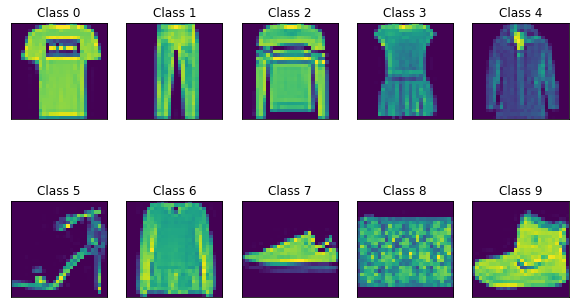

In [10]:
fig = plt.figure(figsize=(10,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    num0_9 = X_train0[y_train0 == i]
    # print(num0_9.shape)
    plt.imshow(num0_9[0]) #, cmap='gray') #, interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])

# Design CNN

### import models, layers, callbacks
- models: Sequential
- layers: Conv2D, MaxPool2D, Flatten
- callbacks: ModelCheckpoint, EarlyStopping

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping

## **CNN2 + FCN2**

In [12]:
c2f2 = keras.models.Sequential([ 
    Conv2D(input_shape=(28,28,1),kernel_size=(3,3),strides=(1,1),filters= 32,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)), 
    Conv2D(kernel_size=(3,3),strides=(1,1),filters= 64,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Flatten(), 
    keras.layers.Dense(128, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(10, activation='softmax')
])

c2f2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

In [13]:
c2f2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               401536    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [14]:
# 1st Conv2D parameters
9*32 + 32

320

In [15]:
# 2nd Conv2D parameters
32*64*3*3 + 64

18496

In [16]:
cp_callback = callbacks.ModelCheckpoint(filepath="./fmnist_c2f2_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy',mode='max', verbose=1, patience=50)
# patience = 10, 20, 50

In [17]:
hist = c2f2.fit(X_train, y_train, epochs = 500 , batch_size =32, 
         callbacks=[cp_callback, es_callback], 
         validation_data=(X_test,y_test))

Epoch 1/500
1875/1875 [==============================] - 12s 6ms/step - loss: 0.4346 - accuracy: 0.8436 - val_loss: 0.3215 - val_accuracy: 0.8860
Epoch 2/500
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2852 - accuracy: 0.8963 - val_loss: 0.2657 - val_accuracy: 0.9027
Epoch 3/500
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2402 - accuracy: 0.9122 - val_loss: 0.2653 - val_accuracy: 0.9035
Epoch 4/500
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2091 - accuracy: 0.9229 - val_loss: 0.2373 - val_accuracy: 0.9141
Epoch 5/500
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1859 - accuracy: 0.9297 - val_loss: 0.2618 - val_accuracy: 0.9087
Epoch 6/500
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1653 - accuracy: 0.9380 - val_loss: 0.2383 - val_accuracy: 0.9183
Epoch 7/500
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1488 - accuracy: 0.9436 - val_loss: 0.2349 -

In [18]:
c2f2.evaluate(X_test, y_test, batch_size =32)

313/313 [==============================] - 1s 4ms/step - loss: 0.8102 - accuracy: 0.9215


[0.8101795315742493, 0.921500027179718]

## **CNN2 + FCN3**

In [26]:
c2f3 = keras.models.Sequential([ 
    Conv2D(input_shape=(28,28,1),kernel_size=(3,3),strides=(1,1),filters= 32,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)), 
    Conv2D(kernel_size=(3,3),strides=(1,1),filters= 64,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Flatten(), 
    keras.layers.Dense(128, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(64, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(10, activation='softmax')
])

c2f3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

In [27]:
c2f3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               401536    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [28]:
cp_callback = callbacks.ModelCheckpoint(filepath="./fmnist_c2f3_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=50)
# patience = 10, 20, 50

In [30]:
hist = c2f3.fit(X_train, y_train, epochs=500, batch_size =32, 
         callbacks=[cp_callback, es_callback], 
         validation_data=(X_test,y_test))

Epoch 1/500
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0778 - accuracy: 0.9718 - val_loss: 0.3701 - val_accuracy: 0.9201
Epoch 2/500
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0773 - accuracy: 0.9721 - val_loss: 0.3405 - val_accuracy: 0.9202
Epoch 3/500
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0730 - accuracy: 0.9732 - val_loss: 0.3648 - val_accuracy: 0.9152
Epoch 4/500
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0696 - accuracy: 0.9746 - val_loss: 0.3884 - val_accuracy: 0.9186
Epoch 5/500
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0696 - accuracy: 0.9749 - val_loss: 0.4015 - val_accuracy: 0.9184
Epoch 6/500
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0656 - accuracy: 0.9766 - val_loss: 0.3749 - val_accuracy: 0.9191
Epoch 7/500
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0639 - accuracy: 0.9772 - val_loss: 0.4081 -

In [31]:
 c2f3.evaluate(X_test, y_test, batch_size = 32)

313/313 [==============================] - 1s 4ms/step - loss: 0.6452 - accuracy: 0.9178


[0.6452382802963257, 0.9178000092506409]

## Graph of loss and accuracy
- model: C2F2

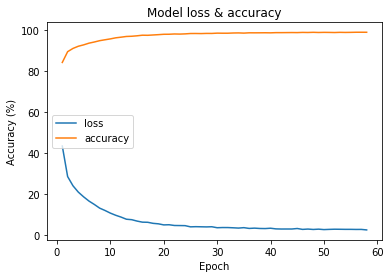

In [19]:
# Plot loss and accuracy
# Plot training & validation accuracy values
epochs = 58
loss_list = [100 * i for i in hist.history['loss']]
acc_list = [100 * i for i in hist.history['accuracy']]
plt.plot(range(1,epochs+1),loss_list) 
plt.plot(range(1,epochs+1),acc_list) 
plt.title('Model loss & accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['loss', 'accuracy'], loc='center left')

In [20]:
vloss_list = [100 * i for i in hist.history['val_loss']]
vacc_list = [100 * i for i in hist.history['val_accuracy']]

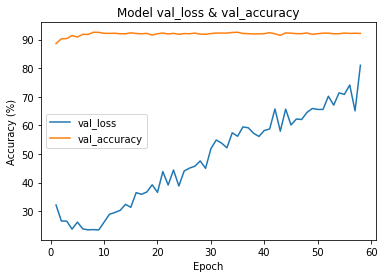

In [21]:
plt.plot(range(1,epochs+1),vloss_list)  
plt.plot(range(1,epochs+1),vacc_list)  
plt.title('Model val_loss & val_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'val_accuracy'], loc='center left')

In [22]:
np.argmax(np.array(vacc_list)) # vacc_list : 검증정확도 리스트

7

In [23]:
vacc_list[np.argmax(np.array(vacc_list))] # 정확도 값

92.5599992275238

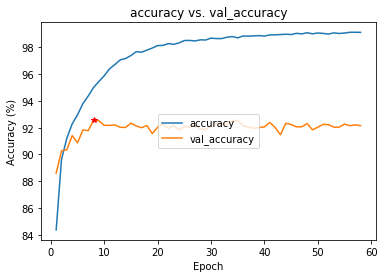

In [24]:
plt.plot(range(1,epochs+1),acc_list)  
plt.plot(range(1,epochs+1),vacc_list)  
plt.title('accuracy vs. val_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['accuracy','val_accuracy'], loc='center')
# 검증 정확도가 가장 높은 부분 마커 표시
plt.plot(np.argmax(np.array(vacc_list))+1,vacc_list[np.argmax(np.array(vacc_list))], 'r*')

## 모형의 저장

- 트레이닝이 끝난 모형은 save 메서드로 가중치와 함께 hdf5 형식으로 저장
- load 명령으로 불러 사용

fmnist_c2f2_best_weights.008-0.9256.hdf5

In [54]:
c2f2.save('fmnist_cnn_best.hdf5')

In [53]:
from keras.models import load_model

model = load_model('fmnist_c2f2_best_weights.008-0.9256.hdf5')
model.evaluate(X_test, y_test, batch_size=32)

313/313 [==============================] - 1s 4ms/step - loss: 0.2357 - accuracy: 0.9256


[0.23569612205028534, 0.925599992275238]

## Graph of loss and accuracy
- model: C2F3

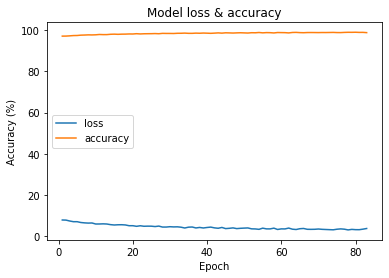

In [32]:
# Plot loss and accuracy
# Plot training & validation accuracy values
epochs = 83
loss_list = [100 * i for i in hist.history['loss']]
acc_list = [100 * i for i in hist.history['accuracy']]
plt.plot(range(1,epochs+1),loss_list) 
plt.plot(range(1,epochs+1),acc_list) 
plt.title('Model loss & accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['loss', 'accuracy'], loc='center left')

In [33]:
vloss_list = [100 * i for i in hist.history['val_loss']]
vacc_list = [100 * i for i in hist.history['val_accuracy']]

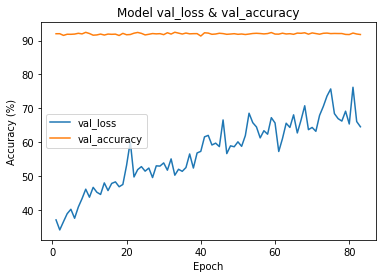

In [34]:
plt.plot(range(1,epochs+1),vloss_list)  
plt.plot(range(1,epochs+1),vacc_list)  
plt.title('Model val_loss & val_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'val_accuracy'], loc='center left')

In [35]:
np.argmax(np.array(vacc_list)) # vacc_list : 검증정확도 리스트

32

In [36]:
vacc_list[np.argmax(np.array(vacc_list))] # 정확도 값

92.44999885559082

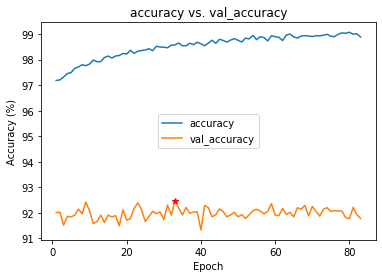

In [37]:
plt.plot(range(1,epochs+1),acc_list)  
plt.plot(range(1,epochs+1),vacc_list)  
plt.title('accuracy vs. val_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['accuracy','val_accuracy'], loc='center')
# 검증 정확도가 가장 높은 부분 마커 표시
plt.plot(np.argmax(np.array(vacc_list))+1,vacc_list[np.argmax(np.array(vacc_list))], 'r*')

## 모형의 저장

- 트레이닝이 끝난 모형은 save 메서드로 가중치와 함께 hdf5 형식으로 저장
- load 명령으로 불러 사용

fmnist_c2f3_best_weights.033-0.9245.hdf5

In [ ]:
# c2f3.save('fmnist_cnn_best.hdf5')

In [38]:
from keras.models import load_model

model = load_model('fmnist_c2f3_best_weights.033-0.9245.hdf5')
model.evaluate(X_test, y_test, batch_size=32)

313/313 [==============================] - 1s 4ms/step - loss: 0.5021 - accuracy: 0.9245


[0.5021327137947083, 0.9244999885559082]

# **[DIY] Hidden layer에 따른 정확도**

In [39]:
score1=c2f2.evaluate(X_test, y_test, batch_size = 32)
score2=c2f3.evaluate(X_test, y_test, batch_size = 32)
losses = [score1[0],score2[0]]
accuracies= [score1[1],score2[1]]
losses,accuracies

313/313 [==============================] - 1s 4ms/step - loss: 0.6452 - accuracy: 0.9178


([0.8101795315742493, 0.6452382802963257],
 [0.921500027179718, 0.9178000092506409])

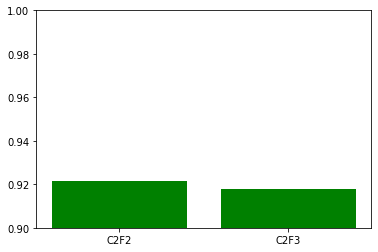

In [45]:
x = np.arange(2)
cnns = ['C2F2','C2F3']

plt.bar(x, accuracies,color='green')
plt.xticks(x, cnns)
plt.ylim((.9,1.0))
plt.show()

## Confusion matrix

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [47]:
predictions = model.predict(X_test)

In [48]:
predictions.shape

(10000, 10)

In [49]:
predictions0 = np.argmax(predictions, axis=1)
predictions0.shape

(10000,)

In [50]:
cm = confusion_matrix(y_test0, predictions0)

In [51]:
class_names =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

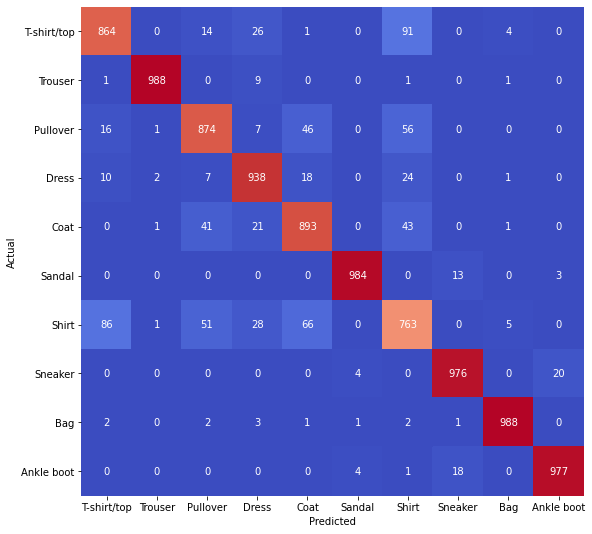

In [52]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, cbar=False, xticklabels=class_names, yticklabels=class_names, fmt='d', annot=True, cmap=plt.cm.coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()